### aim: use pycdftools from julian mak

### date: 

In [187]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [188]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [189]:
import arrow
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/NEMO-related/')
import pyCDFTOOLS
from pyCDFTOOLS.cdfmocsig import *

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [190]:
# load things
%matplotlib inline

from pyCDFTOOLS.cdfmocsig import *

import matplotlib.pyplot as plt
# from matplotlib_colorbar import *

import numpy as np
import glob
import netCDF4, copy

# visualize quantities we are working with

In [191]:
data_dir = '/gpfs/data/greenocean/software/resources/MEDUSA/'

fileT = '/ukesm_allscen_gridT_TS/nemo_cj484o_1m_20480101-20480201_grid-T.nc'
fileV = '/ukesm_allscen_gridV_vo/nemo_cj484o_1m_20480101-20480201_grid-V.nc'

(75, 332)


Text(0.5, 1.05, 'random file, theta0, so, vo, and various sigmas')

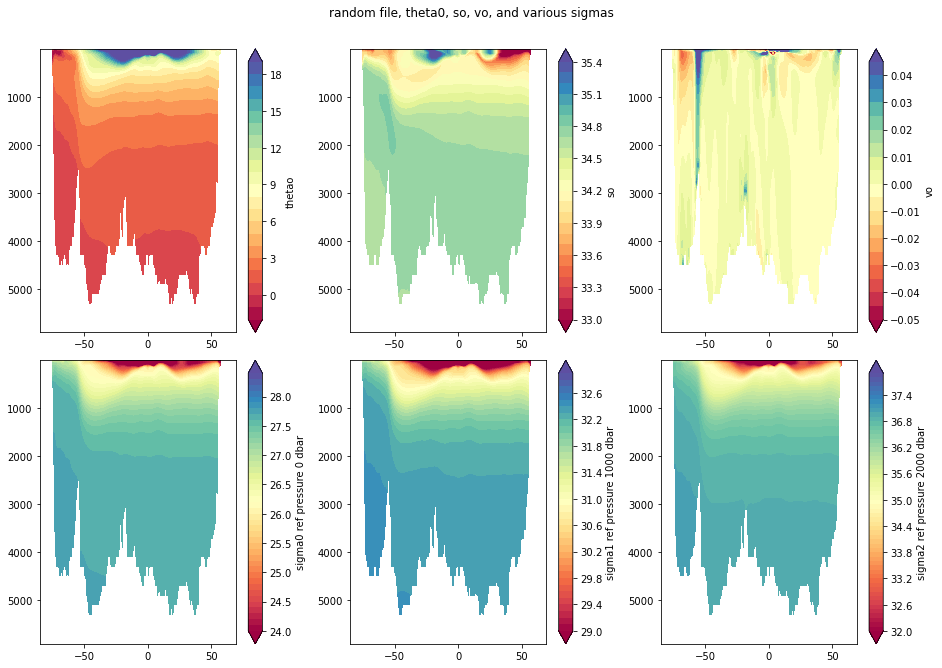

In [192]:
import gsw

tfil = xr.open_dataset(f'{data_dir}/{fileT}')
vfil = xr.open_dataset(f'{data_dir}/{fileV}')
tx = 150
sigma0 = gsw.sigma0(tfil.so[0,:,:,tx], tfil.thetao[0,:,:,tx])
sigma1 = gsw.sigma1(tfil.so[0,:,:,tx], tfil.thetao[0,:,:,tx])
sigma2 = gsw.sigma2(tfil.so[0,:,:,tx], tfil.thetao[0,:,:,tx])

print(np.shape(sigma0))

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].contourf(tfil.nav_lat[:,tx], tfil.deptht, tfil.thetao[0,:,:,tx], np.arange(-2, 20, 1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[0], label = 'thetao')
axs[0].invert_yaxis()

w = axs[1].contourf(tfil.nav_lat[:,tx], tfil.deptht, tfil.so[0,:,:,tx], np.arange(33, 35.5, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[1], label = 'so')
axs[1].invert_yaxis()

w = axs[2].contourf(tfil.nav_lat[:,tx], vfil.depthv, vfil.vo[0,:,:,tx], np.arange(-0.05, 0.05, 0.005), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[2], label = 'vo')
axs[2].invert_yaxis()

ind = 3
w = axs[ind].contourf(tfil.nav_lat[:,tx], tfil.deptht, sigma0, np.arange(24, 28.5, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'sigma0 ref pressure 0 dbar')
axs[ind].invert_yaxis()

ind = 4
w = axs[ind].contourf(tfil.nav_lat[:,tx], tfil.deptht, sigma1, np.arange(29, 33, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'sigma1 ref pressure 1000 dbar')
axs[ind].invert_yaxis()

ind = 5
w = axs[ind].contourf(tfil.nav_lat[:,tx], tfil.deptht, sigma2, np.arange(32, 38, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'sigma2 ref pressure 2000 dbar')
axs[ind].invert_yaxis()
plt.tight_layout()

fig.suptitle('random file, theta0, so, vo, and various sigmas', y = 1.05)

### make wrapper functions for pyCDFtools

    sys.path.append('/gpfs/home/mep22dku/scratch/NEMO-related/')
    import pyCDFTOOLS

In [193]:
def wrap_cdfmocsig(fileV, fileT, tsig = 2000):
    bins = sigma_bins(tsig)
    # print('')
    # print('bins')
    # print(bins)#use the 2000 version. maybe look at where the sigma 
    data_dir = '/gpfs/data/greenocean/software/resources/MEDUSA/'
    # for putting extra options in
    #   -- kt       = number for using a specified time entry (python indexing)
    #   -- kz       = number for using a specified vertical level/layer (python indexing)
    #   -- lprint   = True   for printing out variable names in netcdf file
    #   -- lverb    = True   for printing out more information
    #   -- lg_vvl   = True   for using s-coord (time-varying metric)
    #   -- ldec     = True   decompose the MOC into some components
    #   -- leiv     = True   for adding the eddy induced velocity component
    #        eivv_var = string for EIV-v variable name
    #   -- lisodep  = True   (not yet implemented) output zonal averaged isopycnal depth
    #   -- lntr     = True   (not yet implemented) do binning with neutral density
    kwargs =  {"kt"     : 0,
               "lprint" : False,
               "lg_vvl" : False,
               "ldec"   : False,
               "leiv"   : False,  "eivv_var" : "voce_eiv",
               "lisodep": False,
               "lntr"   : False,
               "lverb"  : True}

    # generate a field
    sigma, depi, latV, dmoc, opt_dic = cdfmocsig(data_dir, fileV, "vo", fileT, "thetao", "so", bins, **kwargs)
    
    return sigma, depi, latV, dmoc, opt_dic



def make_nc(name, times, latV, sigma0, dmoc0, sigma1000, dmoc1000, sigma2000, dmoc2000):

    data_vars = {'dmoc0':(['time_counter', 'sigma0', 'latV'], dmoc0,
    {'units': 'Sv',
    'long_name':'sigma-coordinates overturning, ref pressure 0 dbar'}),

                 'dmoc1000':(['time_counter', 'sigma1000', 'latV'], dmoc1000,
    {'units': 'Sv',
    'long_name':'sigma-coordinates overturning, ref pressure 1000 dbar'}),

                 'dmoc2000':(['time_counter', 'sigma2000', 'latV'], dmoc2000,
    {'units': 'Sv',
    'long_name':'sigma-coordinates overturning, ref pressure 2000 dbar'}),
    }

    coords = {'time_counter': (['time_counter'], times),
 #       'time_centered': (['time_centered'], times),
    'latV': (['latV'],latV),
    'sigma0': (['sigma0'], sigma0),
    'sigma1000': (['sigma1000'], sigma1000),
    'sigma2000': (['sigma2000'], sigma2000),
             }

    attrs = {'made in':'overturning/overturning/sigma_overturning.ipynb',
    'desc': 'concatenate monthly overturning output into yearly and give good dates for later processing'
    }
    savenam = name
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)
    
    return 



#### test wrapper function and visualise

In [194]:
sigma0, depi, latV0, dmoc0, opt_dic0 = wrap_cdfmocsig(fileV, fileT, 0)
sigma1000, depi, latV1000, dmoc1000, opt_dic1000 = wrap_cdfmocsig(fileV, fileT, 1000)
sigma2000, depi, latV2000, dmoc2000, opt_dic2000 = wrap_cdfmocsig(fileV, fileT, 2000)

min density for binning = 23.05
max density for binning = 28.15
slow k loop, progress = 0.00 %...0.13 %...0.27 %...0.40 %...0.53 %...0.67 %...0.80 %...0.93 %...min density for binning = 24.05
max density for binning = 32.75
slow k loop, progress = 0.00 %...0.13 %...0.27 %...0.40 %...0.53 %...0.67 %...0.80 %...0.93 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.13 %...0.27 %...0.40 %...0.53 %...0.67 %...0.80 %...0.93 %...

### test nc function and visualise

In [195]:
do = False
if do:
    name = 'test.nc'
    ds = make_nc(name, times, latV, sigma0, dmoc0, sigma1000, dmoc1000, sigma2000, dmoc2000)

In [199]:
mocfil = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_mocsig/nemo_cj881o_1m_201702_mocsig.nc')

(52,)


Text(0.5, 1.05, 'random file, theta0, so, vo, various sigmas (second row) and various mocs in sigma coordinates')

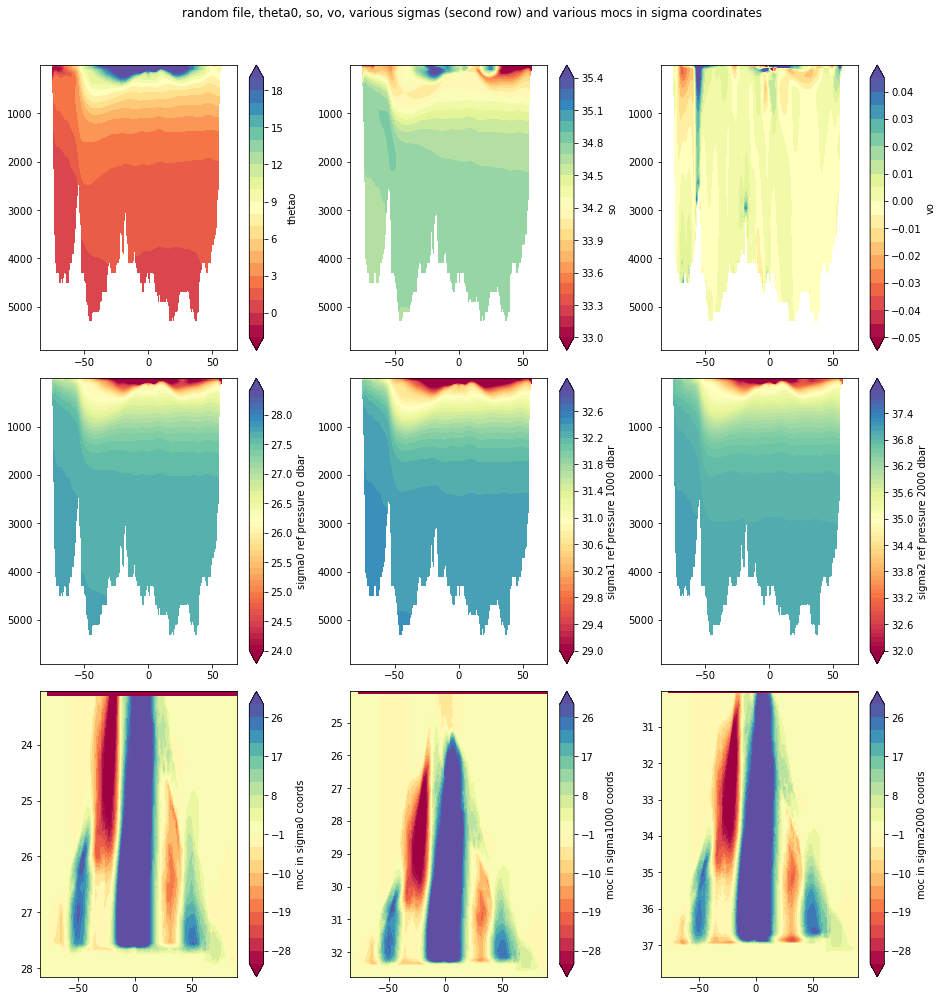

In [200]:
import gsw

tfil = xr.open_dataset(f'{data_dir}/{fileT}')
vfil = xr.open_dataset(f'{data_dir}/{fileV}')
tx = 150
sigma0p = gsw.sigma0(tfil.so[0,:,:,tx], tfil.thetao[0,:,:,tx])
sigma1p = gsw.sigma1(tfil.so[0,:,:,tx], tfil.thetao[0,:,:,tx])
sigma2p = gsw.sigma2(tfil.so[0,:,:,tx], tfil.thetao[0,:,:,tx])

print(np.shape(sigma0))

fact = 1.1
fig, axs = plt.subplots(3,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].contourf(tfil.nav_lat[:,tx], tfil.deptht, tfil.thetao[0,:,:,tx], np.arange(-2, 20, 1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[0], label = 'thetao')
axs[0].invert_yaxis()

w = axs[1].contourf(tfil.nav_lat[:,tx], tfil.deptht, tfil.so[0,:,:,tx], np.arange(33, 35.5, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[1], label = 'so')
axs[1].invert_yaxis()

w = axs[2].contourf(tfil.nav_lat[:,tx], vfil.depthv, vfil.vo[0,:,:,tx], np.arange(-0.05, 0.05, 0.005), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[2], label = 'vo')
axs[2].invert_yaxis()

ind = 3
w = axs[ind].contourf(tfil.nav_lat[:,tx], tfil.deptht, sigma0p, np.arange(24, 28.5, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'sigma0 ref pressure 0 dbar')
axs[ind].invert_yaxis()

ind = 4
w = axs[ind].contourf(tfil.nav_lat[:,tx], tfil.deptht, sigma1p, np.arange(29, 33, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'sigma1 ref pressure 1000 dbar')
axs[ind].invert_yaxis()

ind = 5
w = axs[ind].contourf(tfil.nav_lat[:,tx], tfil.deptht, sigma2p, np.arange(32, 38, 0.1), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'sigma2 ref pressure 2000 dbar')
axs[ind].invert_yaxis()
plt.tight_layout()


ind = 6
w = axs[ind].contourf(mocfil.latV, mocfil.sigma0, mocfil.dmoc0[0,:,:], np.arange(-31, 31, 3), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'moc in sigma0 coords')
axs[ind].invert_yaxis()
plt.tight_layout()

ind = 7
w = axs[ind].contourf(mocfil.latV, mocfil.sigma1000, mocfil.dmoc1000[0,:,:], np.arange(-31, 31, 3), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'moc in sigma1000 coords')
axs[ind].invert_yaxis()
plt.tight_layout()

ind = 8
w = axs[ind].contourf(mocfil.latV, mocfil.sigma2000, mocfil.dmoc2000[0,:,:], np.arange(-31, 31, 3), cmap = 'Spectral', extend = "both")
plt.colorbar(w, ax = axs[ind], label = 'moc in sigma2000 coords')
axs[ind].invert_yaxis()
plt.tight_layout()

fig.suptitle('random file, theta0, so, vo, various sigmas (second row) and various mocs in sigma coordinates', y = 1.05)

### now we can put it together
    
    extraction script goes in `/gpfs/home/mep22dku/scratch/SOZONE/overturning/scriptsSigmaOverturning`

In [198]:
ext = False
if ext:
    exp = 'bc370o'
    start  = '1950-01-01'
    end = '1950-12-01'


    data_dir = '/gpfs/data/greenocean/software/resources/MEDUSA/'
    resdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_mocsig/'

    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('month', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMM')
        month = (tdate.format('MM'))
        year = (tdate.format('YYYY'))
        times = pd.date_range(f"{year}/{month}/01",f"{year}/{month}/02",freq='D',closed='left')


        t_fil = glob.glob(f'{data_dir}/ukesm_allscen_gridT_TS/nemo_{exp}_1m_{ymd}*grid-T.nc')
        q = (t_fil[0])
        w = q.rsplit('/gpfs/data/greenocean/software/resources/MEDUSA/', 1)
        tstr = (w[1])

        v_fil = glob.glob(f'{data_dir}/ukesm_allscen_gridV_vo/nemo_{exp}_1m_{ymd}*grid-V.nc')
        q = (v_fil[0])
        w = q.rsplit('/gpfs/data/greenocean/software/resources/MEDUSA/', 1)
        vstr = (w[1])

        tfil = (tstr)
        vfil = (vstr)
        fnam = f'{resdir}/nemo_{exp}_1m_{ymd}_mocsig.nc'
        print(fnam)
        sigma0, depi, latV0, dmoc0, opt_dic0 = wrap_cdfmocsig(fileV, fileT, 0)
        sigma1000, depi, latV1000, dmoc1000, opt_dic1000 = wrap_cdfmocsig(fileV, fileT, 1000)
        sigma2000, depi, latV2000, dmoc2000, opt_dic2000 = wrap_cdfmocsig(fileV, fileT, 2000)
        make_nc(fnam, times, latV0, sigma0, dmoc0, sigma1000, dmoc1000, sigma2000, dmoc2000)
    

/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_mocsig//nemo_bc370o_1m_195001_mocsig.nc
min density for binning = 23.05
max density for binning = 28.15
slow k loop, progress = 0.00 %...0.13 %...0.27 %...0.40 %...0.53 %...0.67 %...0.80 %...0.93 %...min density for binning = 24.05
max density for binning = 32.75
slow k loop, progress = 0.00 %...0.13 %...0.27 %...0.40 %...0.53 %...0.67 %...0.80 %...0.93 %...

KeyboardInterrupt: 